<a href="https://colab.research.google.com/github/Ninjapack/ai_lab/blob/main/Lab4_20596_cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt


In [9]:
raw_csv_data = np.loadtxt('Audiobooks_data.csv', delimiter=',')

unscaled_inputs_all = raw_csv_data[:, 1:-1]
targets_all = raw_csv_data[:, -1]



In [10]:
shuffled_indices = np.arange(unscaled_inputs_all.shape[0])
np.random.shuffle(shuffled_indices)
unscaled_inputs_all = unscaled_inputs_all[shuffled_indices]
targets_all = targets_all[shuffled_indices]

num_one_targets = int(np.sum(targets_all))
zero_targets_counter = 0
indices_to_remove = []

for i in range(targets_all.shape[0]):
    if targets_all[i] == 0:
        zero_targets_counter += 1
        if zero_targets_counter > num_one_targets:
            indices_to_remove.append(i)

unscaled_inputs_equal_priors = np.delete(unscaled_inputs_all, indices_to_remove, axis=0)
targets_equal_priors = np.delete(targets_all, indices_to_remove, axis=0)


In [11]:
scaled_inputs = preprocessing.scale(unscaled_inputs_equal_priors)

shuffled_indices = np.arange(scaled_inputs.shape[0])
np.random.shuffle(shuffled_indices)
shuffled_inputs = scaled_inputs[shuffled_indices]
shuffled_targets = targets_equal_priors[shuffled_indices]


In [12]:
samples_count = shuffled_inputs.shape[0]
train_samples_count = int(0.8 * samples_count)
validation_samples_count = int(0.1 * samples_count)

train_inputs = shuffled_inputs[:train_samples_count]
train_targets = shuffled_targets[:train_samples_count]

validation_inputs = shuffled_inputs[train_samples_count:train_samples_count+validation_samples_count]
validation_targets = shuffled_targets[train_samples_count:train_samples_count+validation_samples_count]

test_inputs = shuffled_inputs[train_samples_count+validation_samples_count:]
test_targets = shuffled_targets[train_samples_count+validation_samples_count:]


In [13]:
np.savez('Audiobooks_data_train', inputs=train_inputs, targets=train_targets)
np.savez('Audiobooks_data_validation', inputs=validation_inputs, targets=validation_targets)
np.savez('Audiobooks_data_test', inputs=test_inputs, targets=test_targets)


In [14]:
npz = np.load('Audiobooks_data_train.npz')
train_inputs = npz['inputs'].astype(np.float32)
train_targets = npz['targets'].astype(np.int32)

npz = np.load('Audiobooks_data_validation.npz')
validation_inputs = npz['inputs'].astype(np.float32)
validation_targets = npz['targets'].astype(np.int32)

npz = np.load('Audiobooks_data_test.npz')
test_inputs = npz['inputs'].astype(np.float32)
test_targets = npz['targets'].astype(np.int32)


In [15]:
input_size = 10
output_size = 2
hidden_layer_size = 512

model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(hidden_layer_size, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(output_size, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_inputs,
    train_targets,
    batch_size=32,
    epochs=200,
    validation_data=(validation_inputs, validation_targets),
    callbacks=[early_stopping],
    verbose=2
)


Epoch 1/200
112/112 - 5s - 48ms/step - accuracy: 0.7094 - loss: 4.4595 - val_accuracy: 0.7226 - val_loss: 3.7982
Epoch 2/200
112/112 - 2s - 17ms/step - accuracy: 0.7237 - loss: 3.2639 - val_accuracy: 0.7092 - val_loss: 2.7779
Epoch 3/200
112/112 - 1s - 11ms/step - accuracy: 0.7474 - loss: 2.3445 - val_accuracy: 0.7629 - val_loss: 2.0007
Epoch 4/200
112/112 - 1s - 11ms/step - accuracy: 0.7480 - loss: 1.6948 - val_accuracy: 0.7539 - val_loss: 1.4506
Epoch 5/200
112/112 - 1s - 11ms/step - accuracy: 0.7619 - loss: 1.2525 - val_accuracy: 0.7517 - val_loss: 1.1137
Epoch 6/200
112/112 - 1s - 11ms/step - accuracy: 0.7673 - loss: 0.9692 - val_accuracy: 0.7651 - val_loss: 0.8837
Epoch 7/200
112/112 - 1s - 11ms/step - accuracy: 0.7687 - loss: 0.7932 - val_accuracy: 0.7852 - val_loss: 0.7243
Epoch 8/200
112/112 - 1s - 11ms/step - accuracy: 0.7720 - loss: 0.6943 - val_accuracy: 0.7517 - val_loss: 0.6482
Epoch 9/200
112/112 - 1s - 11ms/step - accuracy: 0.7720 - loss: 0.6119 - val_accuracy: 0.7785 - 

In [17]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)
print(f'\nTest loss: {test_loss:.2f}. Test accuracy: {test_accuracy * 100:.2f}%')


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8163 - loss: 0.3916 

Test loss: 0.39. Test accuracy: 81.47%


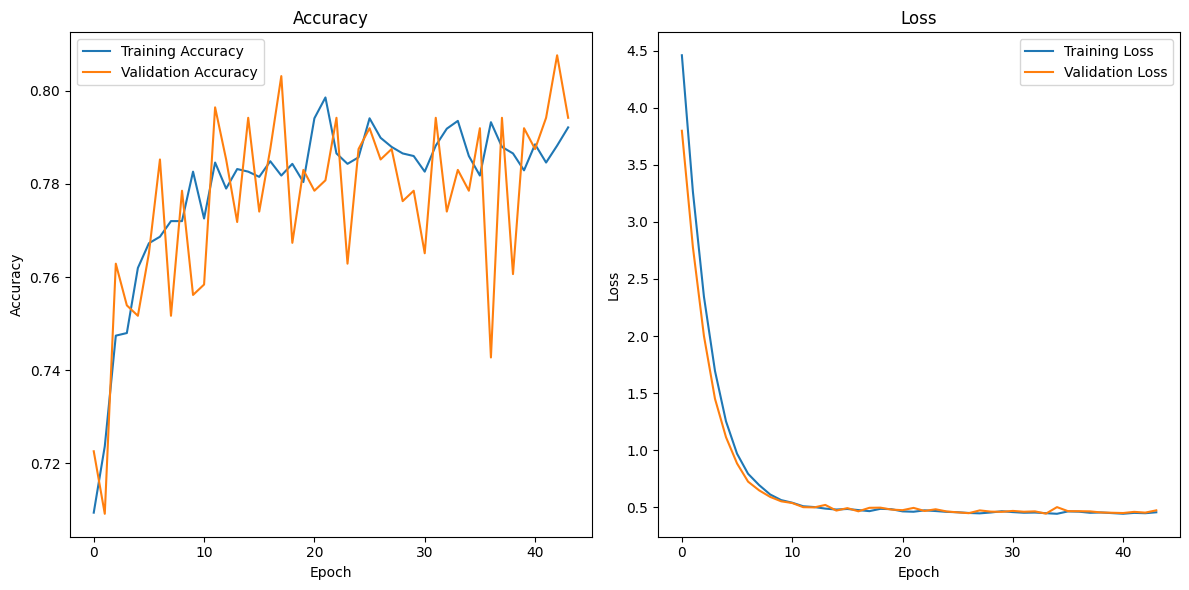

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
